# Example 4: Model Training
First we import the necessary modules

In [10]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from pythermondt import transforms as T
from pythermondt.data import ThermoDataset, DataContainer, random_split
from pythermondt.readers import S3Reader
from example_models.defect_classifier import UNetClassifier

First we define some general parameters for the model training

In [11]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set global random seed for reproducibility
torch.manual_seed(42)

# Model Hyperparameters
epochs = 50
batch_size = 16
learning_rate = 1e-4 # Standard learning rate for Adam optimizer

Now we can the define all the datasources used for training. Here you could specify multiple datasources (which are later combined using the dataset) if you need that. In this example we only use one datasource.

**Note:** For the S3Reader object we set the `download_files` flag to true. Therefore all the files are cached to a folder (.pythermondt_cache) in the current working directory. This makes training way faster, because the files are now only downloaded once and not every time the datasource is loaded. 

In [12]:
folder = "sanity_checked/noise_level0.025 confidence0.5"
base_path = "SAL-Dataset/" + folder
# Specify the datasource
no_defect = S3Reader(
    bucket="ffg-bp",
    prefix=base_path + "/no_defect",
    download_files=True,
    num_files=200
)

visible = S3Reader(
    bucket="ffg-bp",
    prefix=base_path + "/defect_visible",
    download_files=True,
    num_files = 200,
)

Now we can combine these datasources by creating a dataset.

In [13]:
# Create a Dataset
dataset = ThermoDataset(data_source=[no_defect, visible])

Downloading: S3Reader:   0%|          | 0/200 [00:00<?, ?files/s]

Downloading: S3Reader:   0%|          | 0/200 [00:00<?, ?files/s]

Next, we define the transformation pipelines that process the data before it’s fed into the model. For the training set, we apply data-augmentation techniques—such as flipping, rotating, or adding noise to simulate the camera’s NETD—while the test set uses a simpler, non-augmented pipeline. Consequently, we maintain two distinct pipelines: one for training and one for testing.

In [14]:
# Setup transform pipeline for training set
train_pipeline = T.Compose([
    T.ApplyLUT(),
    T.SubtractFrame(0),
    T.RemoveFlash(method='excitation_signal'),
    T.NonUniformSampling(64),
    T.RandomFlip(p_height=0.3, p_width=0.3), # Data Augmentation
    T.GaussianNoise(std=25e-3), # Data Augmentation
    T.MinMaxNormalize(),
])

val_pipeline = T.Compose([
    T.ApplyLUT(),
    T.SubtractFrame(0),
    T.RemoveFlash(method='excitation_signal'),
    T.NonUniformSampling(64),
    T.MinMaxNormalize(),
])

Before we can continue, we first need to write a custom collate function. All the readers and datasets always load data in form of Datacontainer objects. However, when training a model the input data needs to be in form of a tensor. Therefore the collate function extracts the data from all the Datacontainer objects in the current batch and stacks them along the batch dimension. It also makes sure that the shape of the data and the labels match the model input and output shape.

In [15]:
# Custom collate function to extract data and target from the DataContainers in the batch
def collate_fn(batch: list[DataContainer]) -> tuple[torch.Tensor, torch.Tensor]:
    # Extract data and target from the DataContainers
    tdata_list = []
    mask_list = []

    # Extract the data and label from the DataContainer
    for container in batch:
        # Extract datasets from the DataContainer
        tdata = container.get_dataset("/Data/Tdata")
        tdata = tdata.permute(2, 0, 1).float()  # Permute from (H, W, T) -> (T, H, W) and convert to float
        tdata_list.append(tdata)  # Append the tensor to the list
        mask_list.append(0 if container.get_dataset("/GroundTruth/DefectMask").equal(torch.zeros(100,100)) else 1)

    # Stack the tensors along the batch dimension
    data = torch.stack(tdata_list).to(device=device, dtype=torch.float32)
    label = torch.tensor(mask_list, device=device, dtype=torch.float32).unsqueeze(1)


    return data, label

Next we can split the dataset into a training and validation subset, using the random_split function provided with pyThermoNDT. Afterwards the dataloaders for each of the subsets are created.

In [16]:
# Split the dataset in train and test subsets
train_set, val_set = random_split(dataset, [0.8, 0.2], [train_pipeline, val_pipeline])

# Print the length of the subsets
print(f"Train set length: {len(train_set)}")
print(f"Test set length: {len(val_set)}")

# Create a DataLoader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Train set length: 320
Test set length: 80


Now lets verify that the loaders load the data with the correct dimensionality. The models expects the data in **B x T x H x W**:
* B ... Batch size
* H / W ... Height / Width
* T ... Time dimension

In [17]:
for data, label in train_loader:
    print("Data Shape: ", data.shape)
    print("Label Shape: ", label.shape)
    break

Data Shape:  torch.Size([16, 64, 100, 100])
Label Shape:  torch.Size([16, 1])


Now that we have defined all the transform pipelines, lets also verify that the input to the model is correct. Lets plot some images from the training set and test set to see if the transformations are applied correctly.

defect


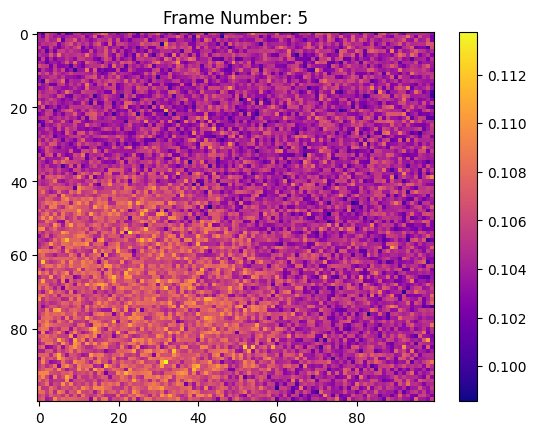

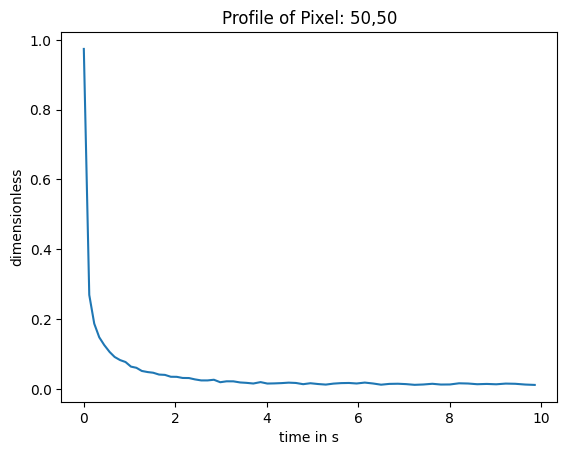

defect


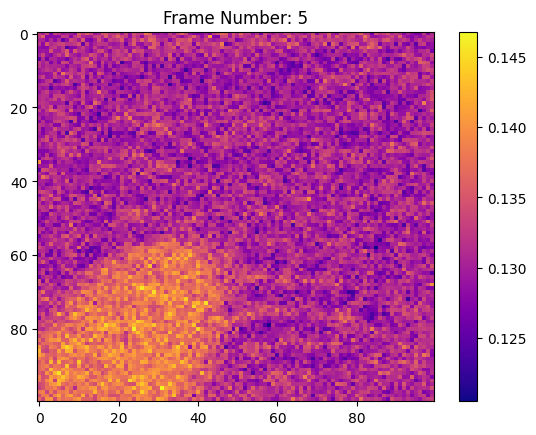

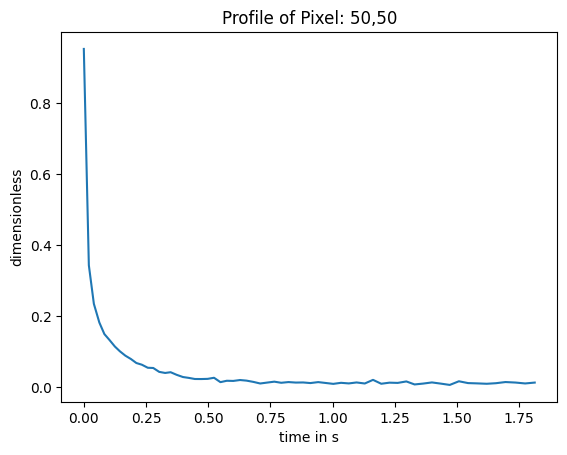

In [18]:
# Visualize the data input
# Visualize a no-defect sample
container = train_set[1]
print("no-defect" if container.get_dataset("/GroundTruth/DefectMask").equal(torch.zeros(100,100)) else "defect")
container.show_frame(5)
container.show_pixel_profile(50, 50)

# Visualize a defect sample
container = train_set[2]
print("no-defect" if container.get_dataset("/GroundTruth/DefectMask").equal(torch.zeros(100,100)) else "defect")
container.show_frame(5)
container.show_pixel_profile(50, 50)

Before the training can start, we also need to define the model, the loss function and the optimizer:

In [19]:
# Define the model and optimizer
model = UNetClassifier(time_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.BCEWithLogitsLoss()

At this point, the training loop can be executed using the following code. This loop is straightforward and consists of only a few lines. For production use, consider adding features such as logging, early stopping, learning rate scheduling, etc.

In [20]:
# Initialize lists to store losses and metrics
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch}")

    # Training phase
    model.train()
    epoch_train_loss = 0.0
    print("Training:")
    
    for batch_idx, (data, label) in enumerate(train_loader):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Compute the loss
        loss = loss_fn(output, label)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate loss
        epoch_train_loss += loss.item()

        # Print the loss every 5 batches
        if batch_idx % 5 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item():.4f}")
    
    # Average training loss for this epoch
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss_summed = 0.0
    correct = 0
    total = 0
    
    print("Validation:")
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(val_loader):
            # Forward pass
            output = model(data)

            # Compute the loss
            loss = loss_fn(output, label)
            val_loss_summed += loss.item()
            
            # Calculate accuracy
            predictions = (torch.sigmoid(output) > 0.5).float()
            total += label.size(0)
            correct += (predictions == label).sum().item()
    
    # Calculate metrics
    avg_val_loss = val_loss_summed / len(val_loader)
    val_accuracy = correct / total
    
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

Epoch 0
Training:
Batch 0, Loss: 0.6941
Batch 5, Loss: 0.6932
Batch 10, Loss: 0.6939
Batch 15, Loss: 0.6980
Validation:
Validation Loss: 0.6929, Accuracy: 0.5125
Epoch 1
Training:
Batch 0, Loss: 0.6932
Batch 5, Loss: 0.6932
Batch 10, Loss: 0.6924
Batch 15, Loss: 0.6944
Validation:
Validation Loss: 0.6934, Accuracy: 0.4875
Epoch 2
Training:
Batch 0, Loss: 0.6908
Batch 5, Loss: 0.6932
Batch 10, Loss: 0.6917
Batch 15, Loss: 0.6906
Validation:
Validation Loss: 0.6934, Accuracy: 0.4875
Epoch 3
Training:
Batch 0, Loss: 0.6919
Batch 5, Loss: 0.6942
Batch 10, Loss: 0.6928
Batch 15, Loss: 0.6937
Validation:
Validation Loss: 0.6925, Accuracy: 0.4875
Epoch 4
Training:
Batch 0, Loss: 0.6932
Batch 5, Loss: 0.6923
Batch 10, Loss: 0.6986
Batch 15, Loss: 0.6768
Validation:
Validation Loss: 0.6448, Accuracy: 0.8125
Epoch 5
Training:
Batch 0, Loss: 0.6886
Batch 5, Loss: 0.6854
Batch 10, Loss: 0.7816
Batch 15, Loss: 0.6946
Validation:
Validation Loss: 0.6935, Accuracy: 0.5125
Epoch 6
Training:
Batch 0, L

After the training loop has finished, the results can be visualized. In this example the loss curves are plotted over the training epochs:

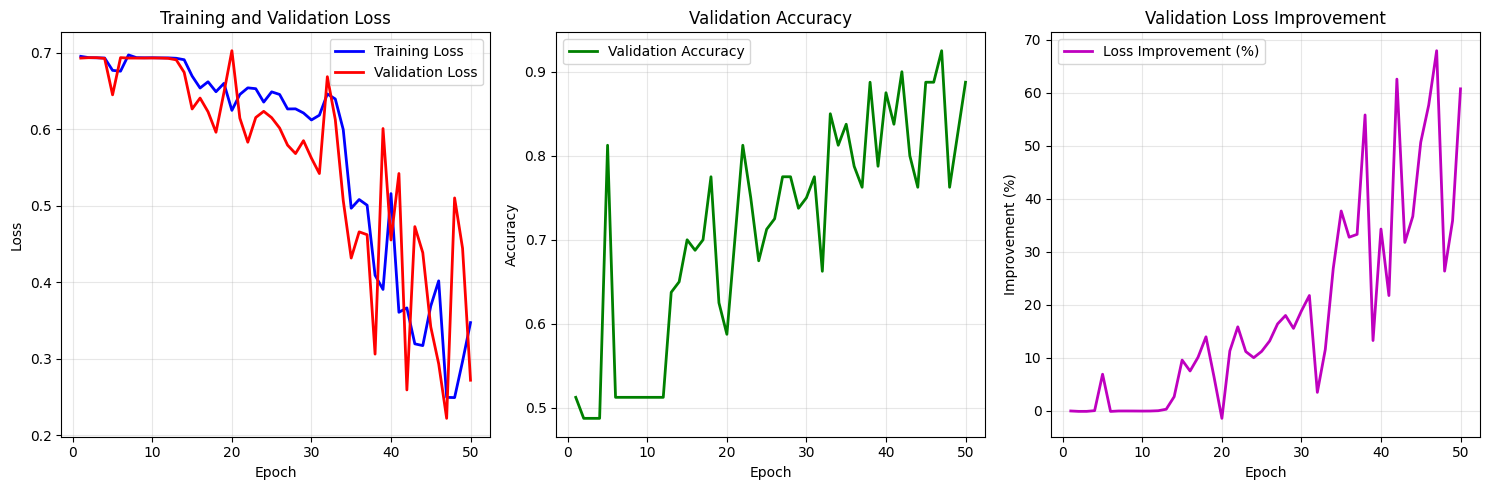

In [21]:
# Create loss curves
plt.figure(figsize=(15, 5))

# Plot 1: Training and Validation Loss
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs + 1), train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(range(1, epochs + 1), val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs + 1), val_accuracies, 'g-', label='Validation Accuracy', linewidth=2)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Loss Improvement
plt.subplot(1, 3, 3)
initial_val_loss = val_losses[0]
loss_improvement = [(initial_val_loss - loss) / initial_val_loss * 100 for loss in val_losses]
plt.plot(range(1, epochs + 1), loss_improvement, 'm-', label='Loss Improvement (%)', linewidth=2)
plt.title('Validation Loss Improvement')
plt.xlabel('Epoch')
plt.ylabel('Improvement (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Finally, the model`s weights are saved to a file. This file can later be used to load the model and make predictions on new data.

In [22]:
# Save the model
torch.save(model.state_dict(), "./example_models/defect_classifier.pth")